In [1]:
import os
import subprocess
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# same function from HW3 to download files
group_num = 9
def download_files(group_num, folders = None, redownload = False):
    node_names = {}
    root_folder = f"Group{group_num}"
    root_folder_exist = os.path.exists(root_folder)
    if (not root_folder_exist) or redownload:
        os.system(f"rm -rf {root_folder}")
        os.mkdir(root_folder)
        if folders is None:
            folders = ['Facebook-Ego', 'Twitter-Ego']
        for folder in folders:
            os.mkdir(os.path.join(root_folder, folder))
            res = subprocess.run(["curl", "-s", f"https://api.github.com/repos/1250326/exercise_complex_network/contents/Datasets/Group{group_num}/{folder}"], stdout=subprocess.PIPE)
            for file_info in json.loads(res.stdout):
                os.system(f"wget -O {os.path.join(root_folder, folder, (fname:=file_info['name']))} {file_info['download_url']} -q")
                print(f"Downloaded file: {fname}")
                # if '.' in fname:
                    # node_names[folder.split('-')[0]] = fname.split('.')[0]
            print(f"Downloaded folder: {folder}")
    
        
    for folder in os.listdir(root_folder):
        for file in os.listdir(os.path.join(root_folder, folder)):
            if '.' in file:
                node_names[folder.split('-')[0]] = file.split('.')[0]
    return node_names

node_names = download_files(group_num, redownload=False)
node_names

Downloaded file: 3437_2.edges
Downloaded file: 3437_2.egofeat
Downloaded file: 3437_2.feat
Downloaded file: 3437_2.featnames
Downloaded file: Description
Downloaded folder: Facebook-Ego
Downloaded file: 6408382.circles
Downloaded file: 6408382.edges
Downloaded file: 6408382.egofeat
Downloaded file: 6408382.feat
Downloaded file: 6408382.featnames
Downloaded file: Description
Downloaded folder: Twitter-Ego


{'Facebook': '3437_2', 'Twitter': '6408382'}

# A
Choose one of the datasets, calculate the betweenness closeness and PageRank mentioned in the
lecture on all of the nodes. Please compare the results. What cause the difference between the
results?

In [67]:
facebook_net = nx.read_edgelist(f"Group{group_num}/Facebook-Ego/{node_names['Facebook']}.edges")
# According to wikipedia, the clossenes
facebook_net = facebook_net.subgraph(max(nx.connected_components(facebook_net), key=len))
print(f"Number of nodes in facebook: {facebook_net.number_of_nodes()}")

Number of nodes in facebook: 97


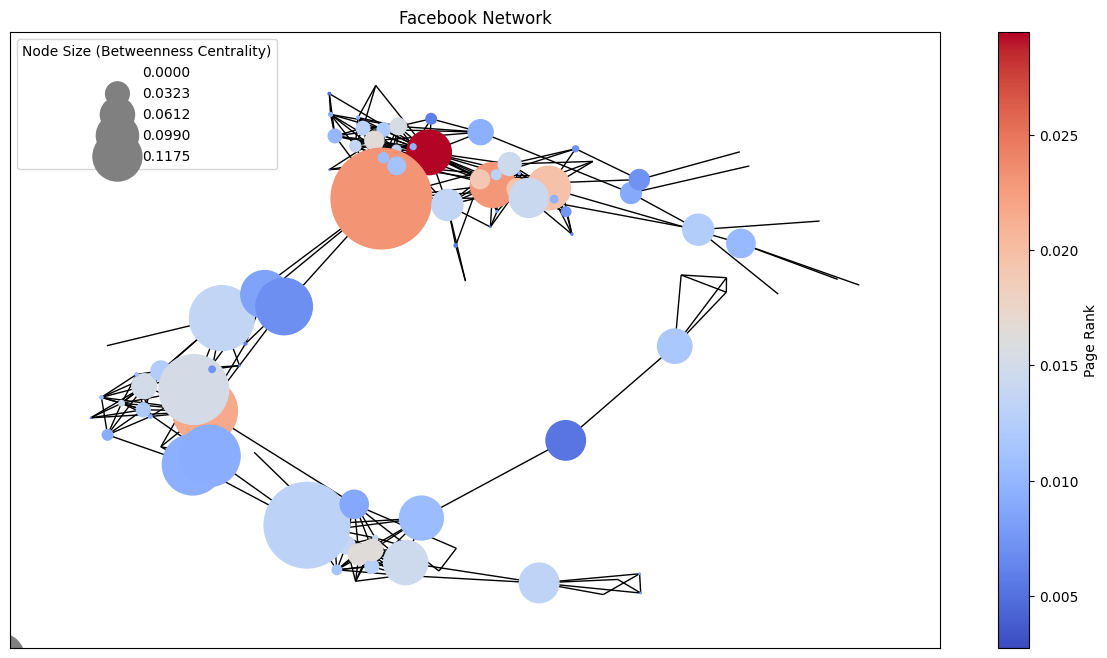

In [106]:
closeness = nx.betweenness_centrality(facebook_net)
page_rank = nx.pagerank(facebook_net)

nodes_size = {node: closeness[node]* 10000 for node in facebook_net.nodes}


plt.figure(figsize=(15, 8))
sm = nx.draw_networkx_nodes(
    facebook_net,
    pos:=nx.spring_layout(facebook_net, k=0.5, iterations=100, seed=42),
    node_size=[nodes_size[node] for node in facebook_net.nodes],
    node_color=[page_rank[node] for node in facebook_net.nodes],
    cmap="coolwarm",
)
nx.draw_networkx_edges(
    facebook_net,
    pos,
)

# Add legend for size
for s in np.linspace(min(nodes_size.values()), max(nodes_size.values())/4, 5):
    plt.scatter([], [], s=s, edgecolors='none', color='gray', label=f"{closeness[min(nodes_size, key=lambda x: abs(nodes_size[x]-s))]:.4f}")

plt.title("Facebook Network")
plt.colorbar(sm, label="Page Rank")
plt.legend(title="Node Size (Betweenness Centrality)")

plt.show()

We can see the nodes with the highest page rank have a betweenness closeness as well. This is because the nodes with the highest betweenness closeness are the nodes that are most central to the network. These nodes are the most important nodes in the network and are the nodes that are most likely to be visited by a random walker. The nodes with the highest PageRank are the nodes that are most likely to be visited by a random walker. Therefore, the nodes with the highest betweenness closeness are also the nodes with the highest PageRank.

But there are some nodes with high betweenness closeness but low PageRank. This is because the betweenness closeness is a measure of how central a node is to the network, while the PageRank is a measure of how important a node is to the network. The nodes with high betweenness closeness but low PageRank are the nodes that are central to the network but are not important to the network. These nodes are the nodes that are most likely to be visited by a random walker, but are not important to the network.

# B
This question is duplicated with the previous one. Please refer to the previous question.

# C
Please plot the largest strong connected component in the Twitter-Ego dataset.

In [69]:
twitter_net = nx.read_edgelist(f"Group{group_num}/Twitter-Ego/{node_names['Twitter']}.edges", create_using=nx.DiGraph, nodetype=int)
print(f"Number of nodes in twitter: {twitter_net.number_of_nodes()}")

Number of nodes in twitter: 151


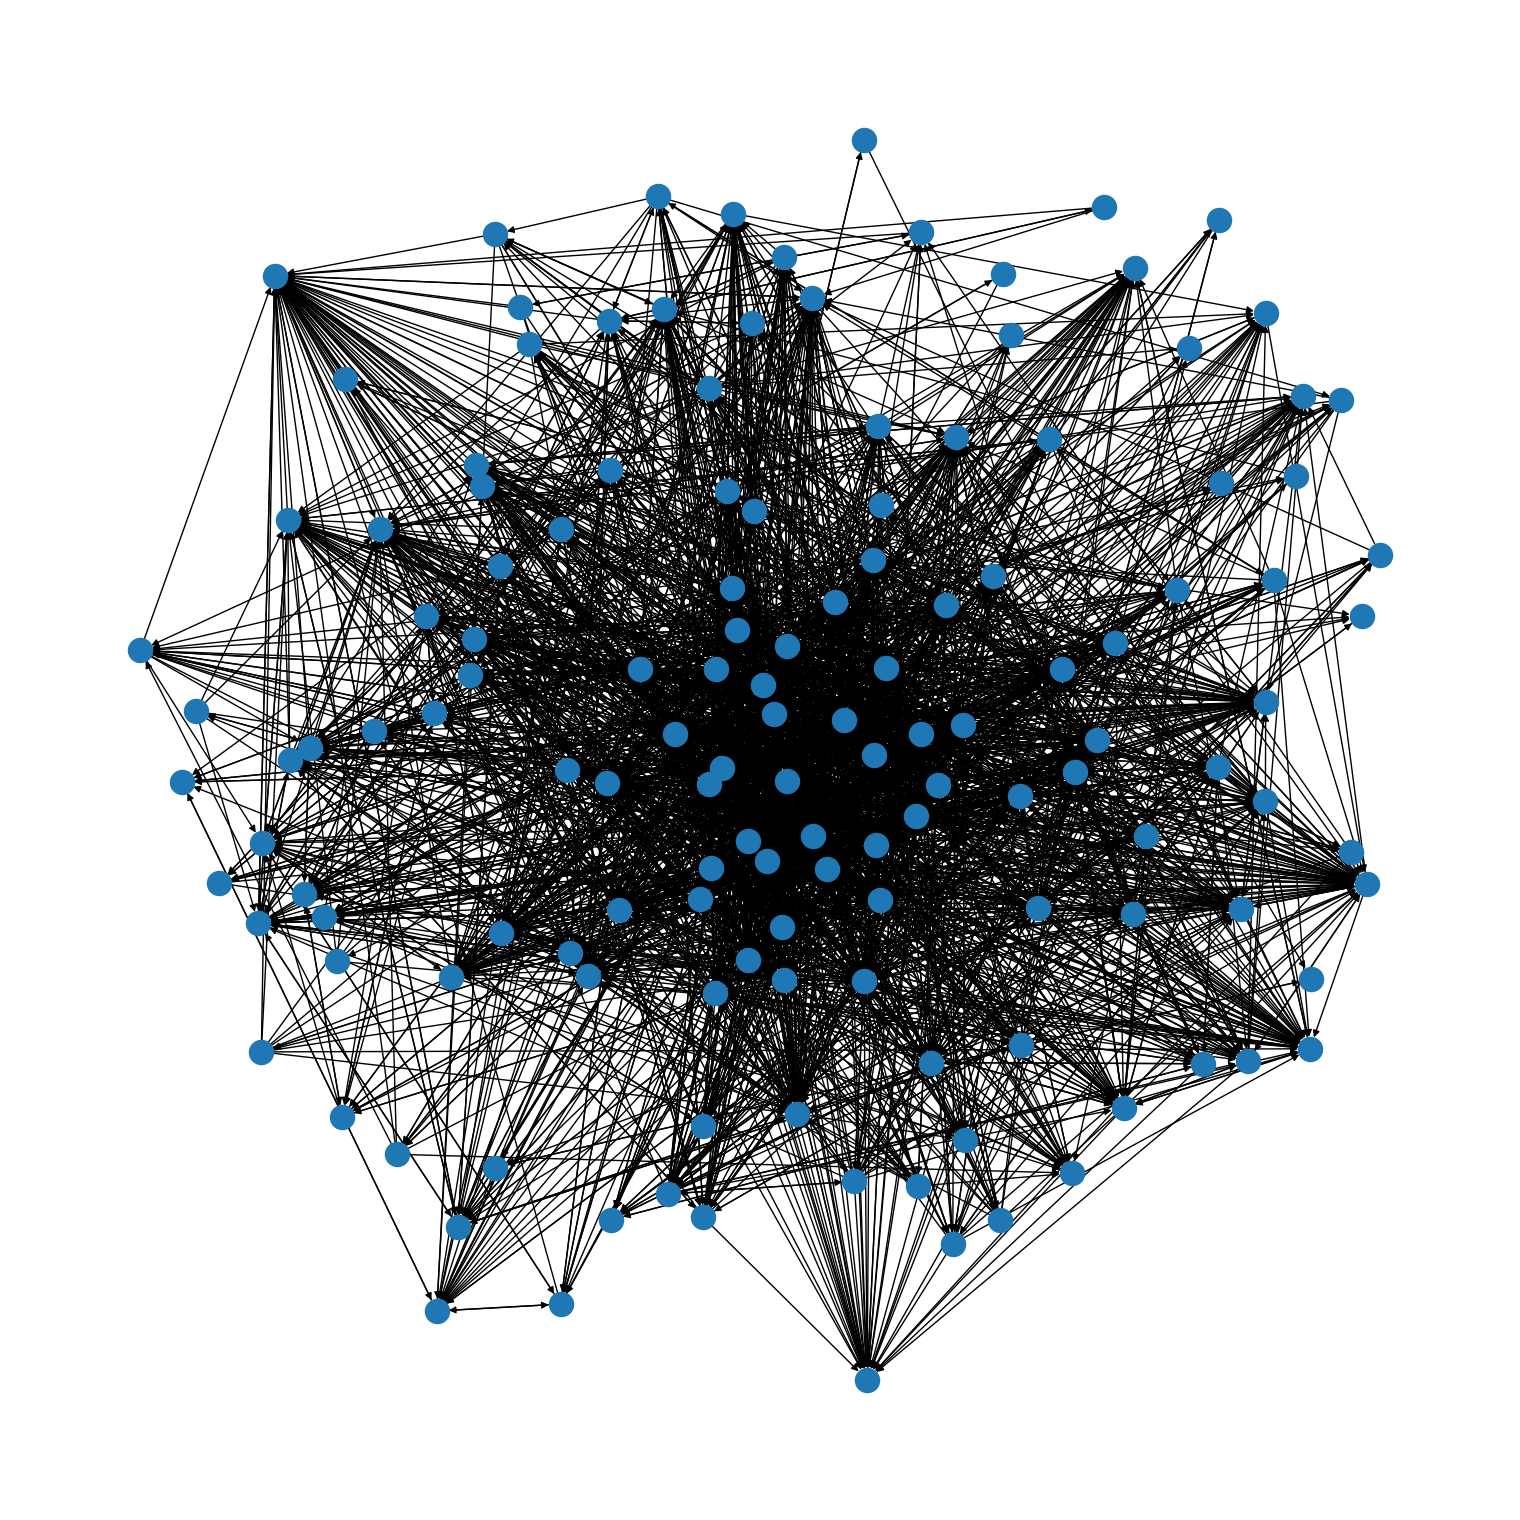

In [70]:
plt.figure(figsize=(15, 15))
nx.draw(
    sub_g:=twitter_net.subgraph(max(nx.strongly_connected_components(twitter_net), key=len)),
    pos=nx.spring_layout(sub_g, k=0.5, iterations=10, seed=42),
    with_labels=False,
)

# D
Choose the results of one of the two algorithms mentioned in question (a), and choose the node
with the highest value and the node with lowest value. Please plot the distributions of Jaccard
similarity, cosine similarity and normalized Euclidean distance between either of the two nodes
and the rest of the nodes in the graph.

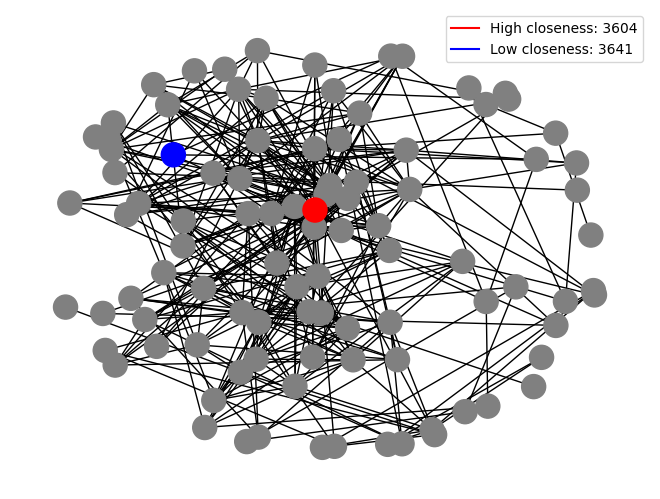

In [72]:
high_node = max(facebook_net.nodes, key=lambda x: closeness[x])
low_node = min(facebook_net.nodes, key=lambda x: closeness[x])



nx.draw(
    facebook_net,
    pos=nx.spring_layout(facebook_net, k=2, iterations=100, seed=42),
    node_color=[{high_node: "red", low_node: "blue"}.get(node, "gray") for node in facebook_net.nodes],
    cmap="coolwarm",
    with_labels=False,
)
plt.plot(0, 0, color="red", label=f"High closeness: {high_node}")
plt.plot(0, 0, color="blue", label=f"Low closeness: {low_node}")
plt.legend()

In [110]:
list(nx.jaccard_coefficient(facebook_net, [(high_node, low_node)]))

[('3604', '3641', 0.0)]

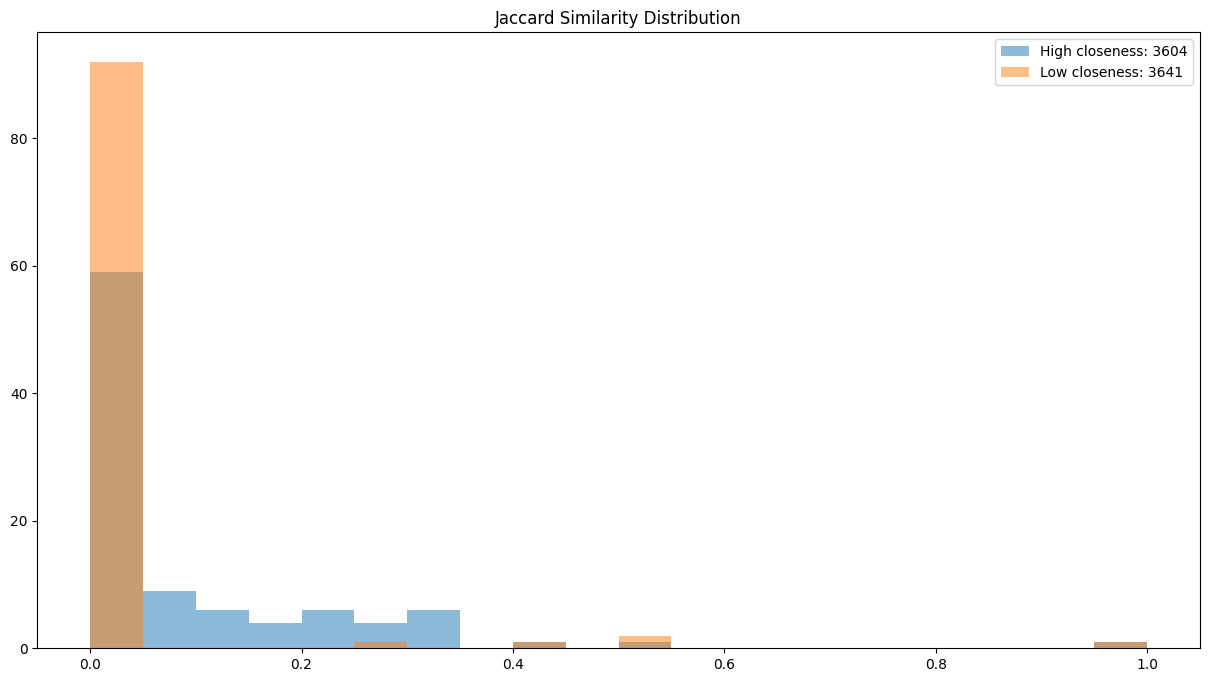

In [111]:
# plot the distribution of jacaard similarity
plt.figure(figsize=(15, 8))
plt.hist(
    [list(nx.jaccard_coefficient(facebook_net, [(high_node, node)]))[0][2] for node in facebook_net.nodes],
    bins=20,
    alpha=0.5,
    label=f"High closeness: {high_node}",
)
plt.hist(
    [list(nx.jaccard_coefficient(facebook_net, [(low_node, node)]))[0][2] for node in facebook_net.nodes],
    bins=20,
    alpha=0.5,
    label=f"Low closeness: {low_node}",
)
plt.legend()
plt.title("Jaccard Similarity Distribution")
plt.show()

$$
    \frac{|N(v1) \cap N(v2)|}{\sqrt{|N(v1)| \cdot |N(v2)|}}
    $$

In [114]:
def cosine_similarity(v1, v2, graph):
    """
    The cosine similarity between two nodes in a graph is:
    $$
    \frac{|N(v1) \cap N(v2)|}{\sqrt{|N(v1)| \cdot |N(v2)|}}
    $$

    Args:
        v1 (node): The first node
        v2 (node): The second node
        graph (nx.Graph): The graph
    """
    v1_neighbors = set(graph.neighbors(v1))
    v2_neighbors = set(graph.neighbors(v2))
    return len(v1_neighbors & v2_neighbors) / np.sqrt(len(v1_neighbors) * len(v2_neighbors))

print(f"Cosine similarity between {high_node} and {low_node}: {cosine_similarity(high_node, low_node, facebook_net)}")

Cosine similarity between 3604 and 3641: 0.0


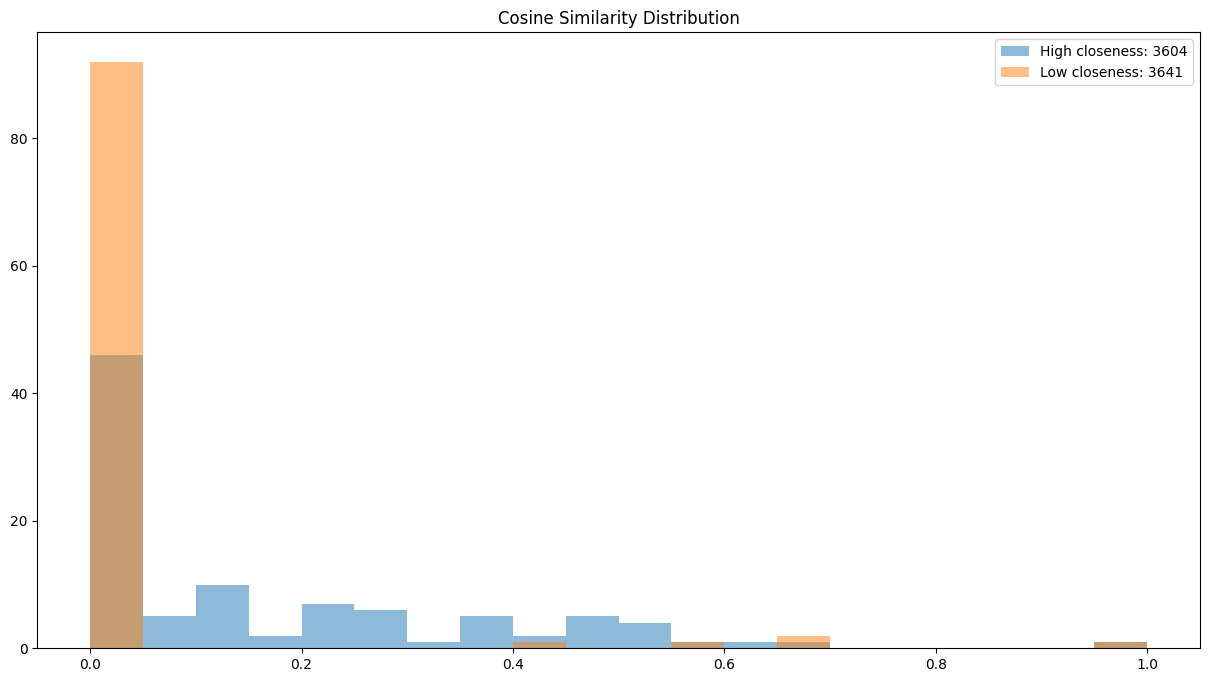

In [116]:
# plot the distribution of cosine similarity
plt.figure(figsize=(15, 8))
plt.hist(
    [cosine_similarity(high_node, node, facebook_net) for node in facebook_net.nodes],
    bins=20,
    alpha=0.5,
    label=f"High closeness: {high_node}",
)
plt.hist(
    [cosine_similarity(low_node, node, facebook_net) for node in facebook_net.nodes],
    bins=20,
    alpha=0.5,
    label=f"Low closeness: {low_node}",
)
plt.legend()
plt.title("Cosine Similarity Distribution")
plt.show()

In [119]:
high_node

'3604'

In [123]:
adj_matrix = nx.to_numpy_array(facebook_net)
high_node_index = list(facebook_net.nodes).index(high_node)
low_node_index = list(facebook_net.nodes).index(low_node)
print(f"Eucledian distance between {high_node} and {low_node}: {np.sum((adj_matrix[high_node_index] - adj_matrix[low_node_index])**2)}")

Eucledian distance between 3604 and 3641: 22.0


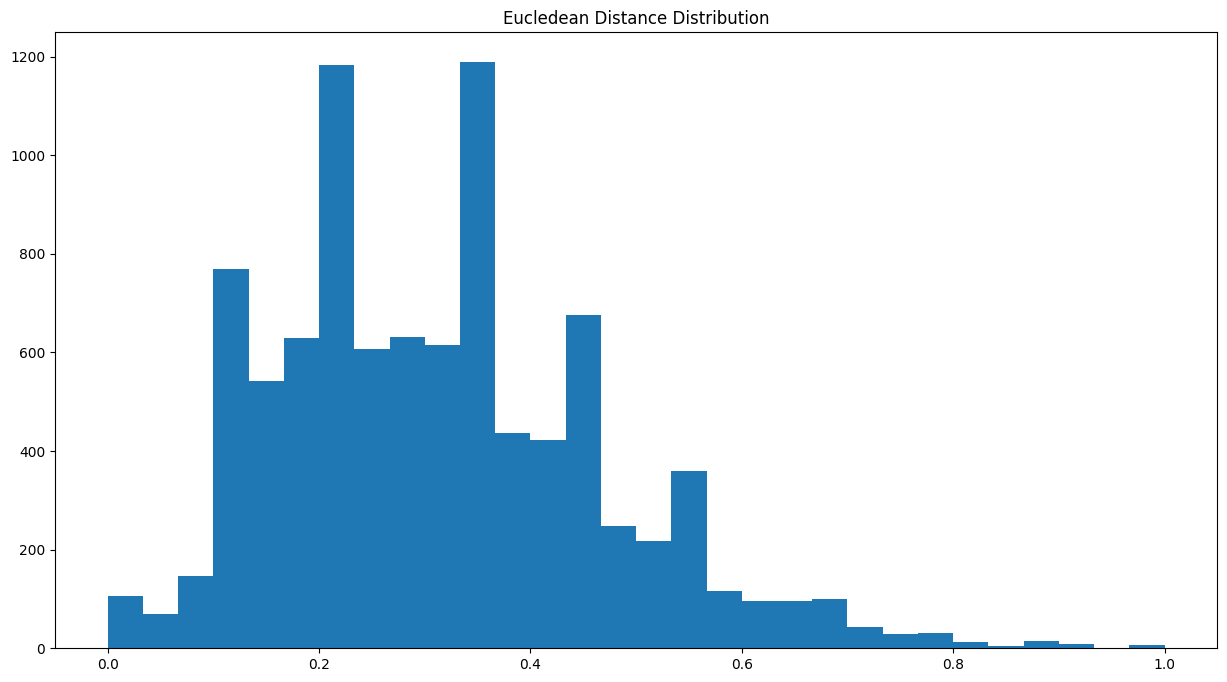

In [127]:
eucledean_distances = np.zeros_like(adj_matrix)
for i in range(eucledean_distances.shape[0]):
    for j in range(eucledean_distances.shape[1]):
        if i < j:
            continue
        eucledean_distances[i, j] = np.sum((adj_matrix[i] - adj_matrix[j])**2)
        eucledean_distances[j, i] = eucledean_distances[i, j]

eucledean_distances /= eucledean_distances.max()

plt.figure(figsize=(15, 8))
plt.hist(
    eucledean_distances.flatten(),
    bins=30,
)
plt.title("Eucledean Distance Distribution")
plt.show()
